# Analysis of Test1712_4 (Stationary with Handlebar Push)

**Objective:** Synchronize TDMS and Xsens data using the `Timestamp` column and verify alignment by comparing the suspension response (TDMS) with Z-axis acceleration (Xsens) during a handlebar push event.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nptdms import TdmsFile
import os

# File Paths
tdms_path = r"c:\Users\es-sabar\Documents\PreTest\Sync\Test1712_4.tdms"
xsens_path = r"c:\Users\es-sabar\Documents\PreTest\Sync\Test1712_4_arret rapide.txt"

print(f"TDMS Path: {tdms_path}")
print(f"Xsens Path: {xsens_path}")

TDMS Path: c:\Users\es-sabar\Documents\PreTest\Sync\Test1712_4.tdms
Xsens Path: c:\Users\es-sabar\Documents\PreTest\Sync\Test1712_4_arret rapide.txt


## 1. Load TDMS Data

In [6]:
try:
    tdms_file = TdmsFile.read(tdms_path)
    print("TDMS file loaded successfully.")
    
    # List groups/channels for verification
    group_name = 'P1' # Default assumption
    if group_name not in tdms_file.groups():
        group_name = tdms_file.groups()[0].name
        
    print(f"Using Group: {group_name}")
    group = tdms_file[group_name]
    df_tdms = group.as_dataframe()
    
    # Ensure Timestamp is datetime
    if 'Timestamp' in df_tdms.columns:
        df_tdms['Timestamp'] = pd.to_datetime(df_tdms['Timestamp'])
        print("TDMS Timestamp range:", df_tdms['Timestamp'].min(), "to", df_tdms['Timestamp'].max())
    else:
        print("ERROR: 'Timestamp' column missing in TDMS!")

except Exception as e:
    print(f"Error loading TDMS: {e}")

TDMS file loaded successfully.
Using Group: arret rapide
TDMS Timestamp range: 2025-12-17 16:48:39.786883 to 2025-12-17 16:49:08.784368


## 2. Load Xsens Data (with UTC Parsing)

In [7]:
try:
    # Auto-detect header row
    header_row = 0
    with open(xsens_path, 'r', encoding='utf-8', errors='ignore') as f:
        for i in range(50):
            line = f.readline()
            if "PacketCounter" in line and "Acc_Z" in line:
                header_row = i
                break
    print(f"Xsens Header Detected at line: {header_row}")
    
    df_xsens = pd.read_csv(xsens_path, skiprows=header_row, sep='\t')
    
    # Construct Timestamp from UTC columns
    # Xsens columns usually: UTC_Year, UTC_Month, UTC_Day, UTC_Hour, UTC_Minute, UTC_Second, UTC_Nano
    required_cols = ['UTC_Year', 'UTC_Month', 'UTC_Day', 'UTC_Hour', 'UTC_Minute', 'UTC_Second', 'UTC_Nano']
    if all(col in df_xsens.columns for col in required_cols):
        df_xsens['Timestamp'] = pd.to_datetime(dict(
            year=df_xsens['UTC_Year'], 
            month=df_xsens['UTC_Month'], 
            day=df_xsens['UTC_Day'], 
            hour=df_xsens['UTC_Hour'], 
            minute=df_xsens['UTC_Minute'], 
            second=df_xsens['UTC_Second']
        )) + pd.to_timedelta(df_xsens['UTC_Nano'], unit='ns')
        
        # Localize/Convert if necessary (TDMS usually is local time or UTC? User modified it.. assumming compatible)
        # But check timezone awareness. Usually pd.to_datetime makes naive timestamps unless kwarg provided.
        
        print("Xsens Timestamp constructed.")
        print("Range:", df_xsens['Timestamp'].min(), "to", df_xsens['Timestamp'].max())
    else:
        print("WARNING: UTC columns missing. Available:", df_xsens.columns.tolist())
        
except Exception as e:
    print(f"Error loading Xsens: {e}")

Xsens Header Detected at line: 12
Xsens Timestamp constructed.
Range: 2025-12-18 10:38:22.225394149 to 2025-12-18 10:38:51.040399388


## 3. Compare and Plot

Potential Suspension Channels: ['Deb_Susp_AVG_Moto', 'Deb_Susp_AVD_Moto']


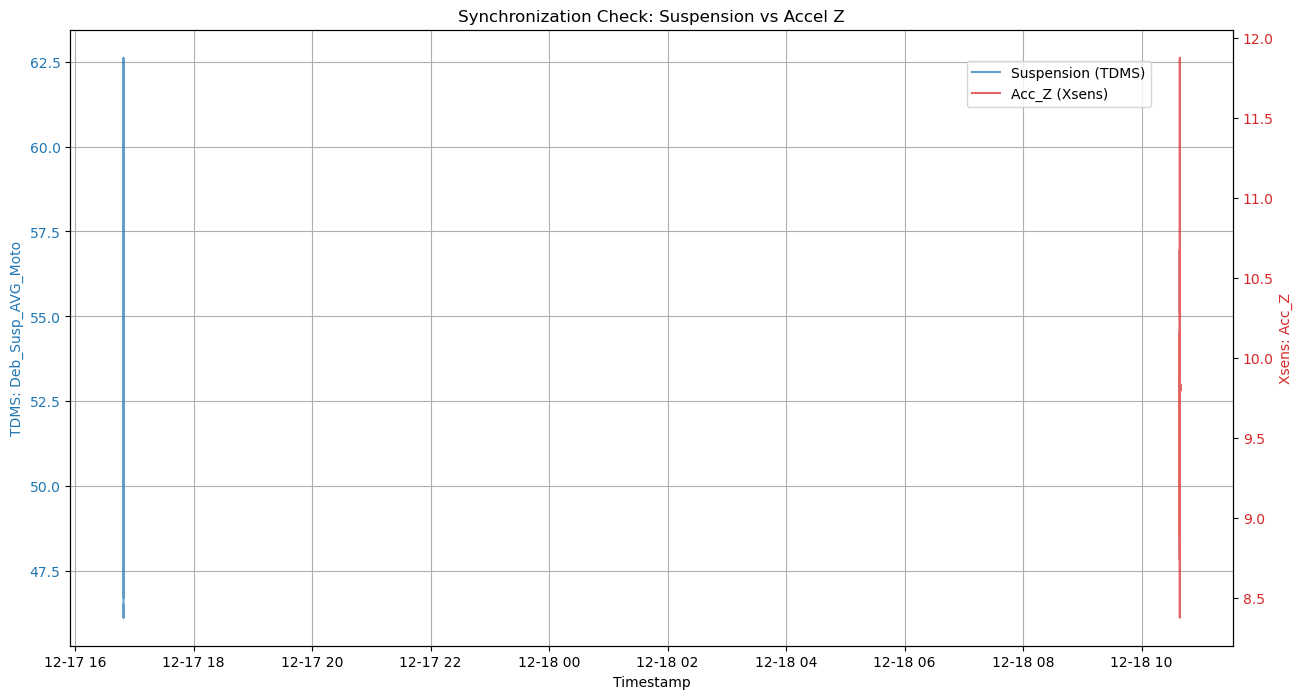

In [4]:
# Find relevant columns
# TDMS Suspension
susp_cols = [c for c in df_tdms.columns if 'susp' in c.lower() or 'fourche' in c.lower() or 'course' in c.lower()]
print("Potential Suspension Channels:", susp_cols)
susp_col = susp_cols[0] if susp_cols else df_tdms.columns[1] # Fallback

# Xsens Acc_Z
acc_col = 'Acc_Z'

# Setup Plot
fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel(f'TDMS: {susp_col}', color=color)
ax1.plot(df_tdms['Timestamp'], df_tdms[susp_col], color=color, label='Suspension (TDMS)', alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Twin axis for Xsens
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(f'Xsens: {acc_col}', color=color)
ax2.plot(df_xsens['Timestamp'], df_xsens[acc_col], color=color, label='Acc_Z (Xsens)', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Synchronization Check: Suspension vs Accel Z')
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
plt.show()

In [5]:
# Detail View (Zoom in on the event if possible)
# If we can detect the peak, we can auto-zoom.
try:
    # Simple peak detection on Acc_Z
    peak_idx = df_xsens[acc_col].abs().idxmax()
    peak_time = df_xsens.loc[peak_idx, 'Timestamp']
    
    print(f"Peak Acc_Z detected at: {peak_time}")
    
    # Zoom +/- 5 seconds around peak
    zoom_start = peak_time - pd.Timedelta(seconds=5)
    zoom_end = peak_time + pd.Timedelta(seconds=5)
    
    ax1.set_xlim(zoom_start, zoom_end)
    plt.draw()
except Exception as e:
    print(f"Auto-zoom failed: {e}")

Peak Acc_Z detected at: 2025-12-18 10:38:36.010402376


<Figure size 640x480 with 0 Axes>